In [12]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import itertools
from tqdm import tqdm_notebook

In [2]:
df = pd.read_csv("COMBINED_RAJASTHAN1_2000-14.csv")

In [3]:
df=df.assign(datetime_val=[f"{str(year)}{str(month)}{str(day)}" for year, month, day in zip(df['Year'], df['Month'], df['Day'])])

In [4]:
first_column = df.pop('datetime_val')
  
df.insert(0, 'datetime_val', first_column)

In [5]:
df['datetime_val'] = pd.to_datetime(df['datetime_val'], format='%Y%m%d')
df_time = df.set_index('datetime_val')

In [6]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot') 

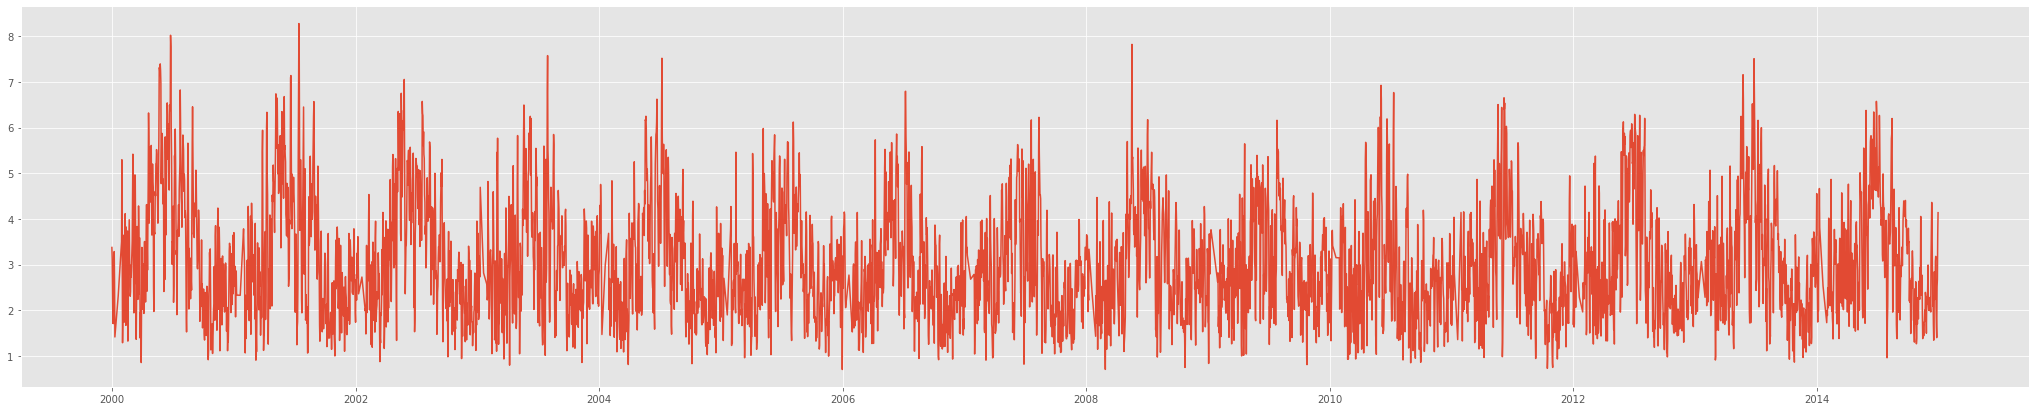

In [7]:
data = [df['datetime_val'],df['Wind Speed']]
headers = ["date_time","Wind Speed"]
temp_df = pd.concat(data,axis=1,keys=headers)
daily_RJ = temp_df.groupby(temp_df['date_time'].dt.date).agg({'Wind Speed': 'mean'}).reset_index()
# print(temp_df)
# monthly_AP = temp_df.groupby(temp_df['date_time'].dt.month).agg({'GHI':'sum'}).reset_index()
daily_RJ.set_index('date_time')
plt.rcParams["figure.figsize"] = (36,7)

plt.plot(daily_RJ['date_time'],daily_RJ['Wind Speed'])

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [9]:
train_data_len = int((len(daily_RJ)*13)/15)
train_data = daily_RJ['Wind Speed'][0:train_data_len]
test_data = daily_RJ['Wind Speed'][train_data_len:len(daily_RJ)]

# AR

In [10]:
# Rolling forecast for AR
history = train_data.copy()

predictions = []
weekly = []
monthly = []
for t in range(len(test_data)):
  modelAR = ARIMA(history,order = (8,0,0))
  model_fit = modelAR.fit()

  if (t)%7==0:
    forecast = model_fit.predict(start=t+train_data_len, end=t+train_data_len+6)
    # print(forecast)
    for i in range(7):
      weekly.append(forecast[train_data_len+t+i])
  
  if (t)%30==0:
    forecast = model_fit.predict(start=t+train_data_len, end=t+train_data_len+29)
    # print(forecast)
    for i in range(30):
      monthly.append(forecast[train_data_len+t+i])

  output = model_fit.forecast()
  predVal = output[train_data_len+t]
  predictions.append(predVal)
  history[len(history)] = test_data[train_data_len+t]

Mean Absolute Percentage Error: 22.976197960069562 %
Mean Sqaured Error: 0.6001263919111973


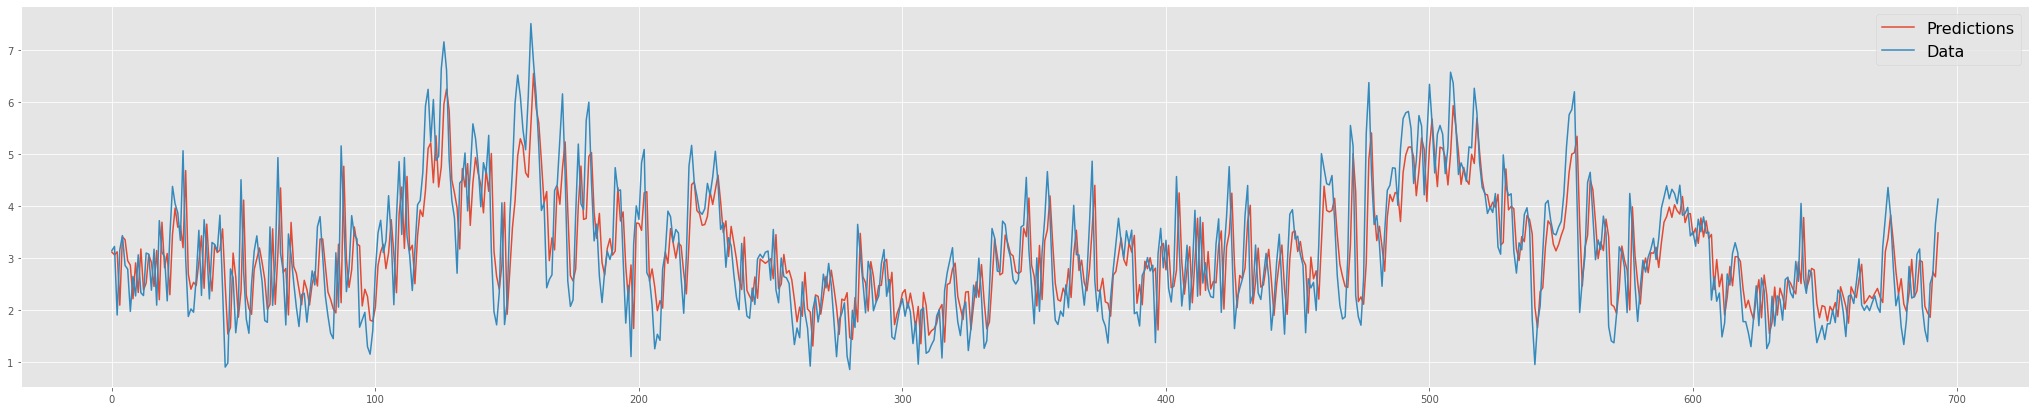

In [13]:
percentage = []
for i in range(len(predictions)):
  percentage.append((abs(predictions[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,predictions)
print("Mean Sqaured Error: {0}".format(mse))

plt.plot(predictions)
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 31.044101547578723 %
Mean Sqaured Error: 1.041960405753321


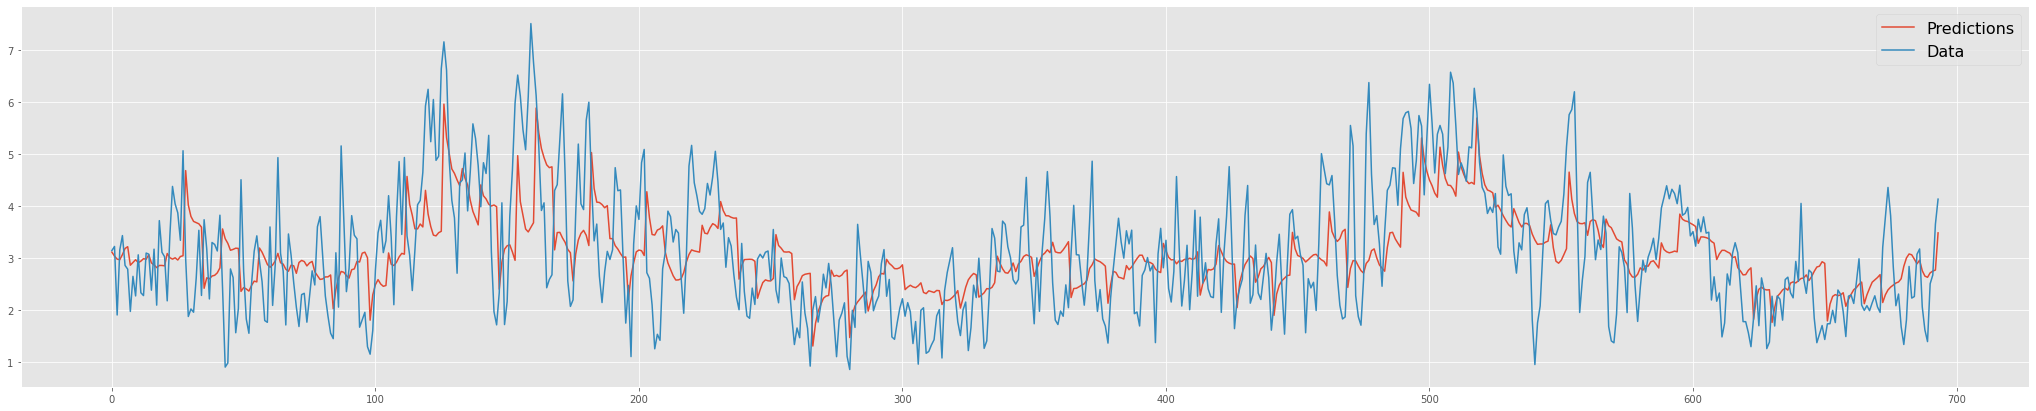

In [14]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(weekly[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,weekly[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks after training dataset.
# plt.plot(weekly[14:28])
# plt.plot(test_points[14:28])

plt.plot(weekly[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 33.18264894206944 %
Mean Sqaured Error: 1.3128296647529256


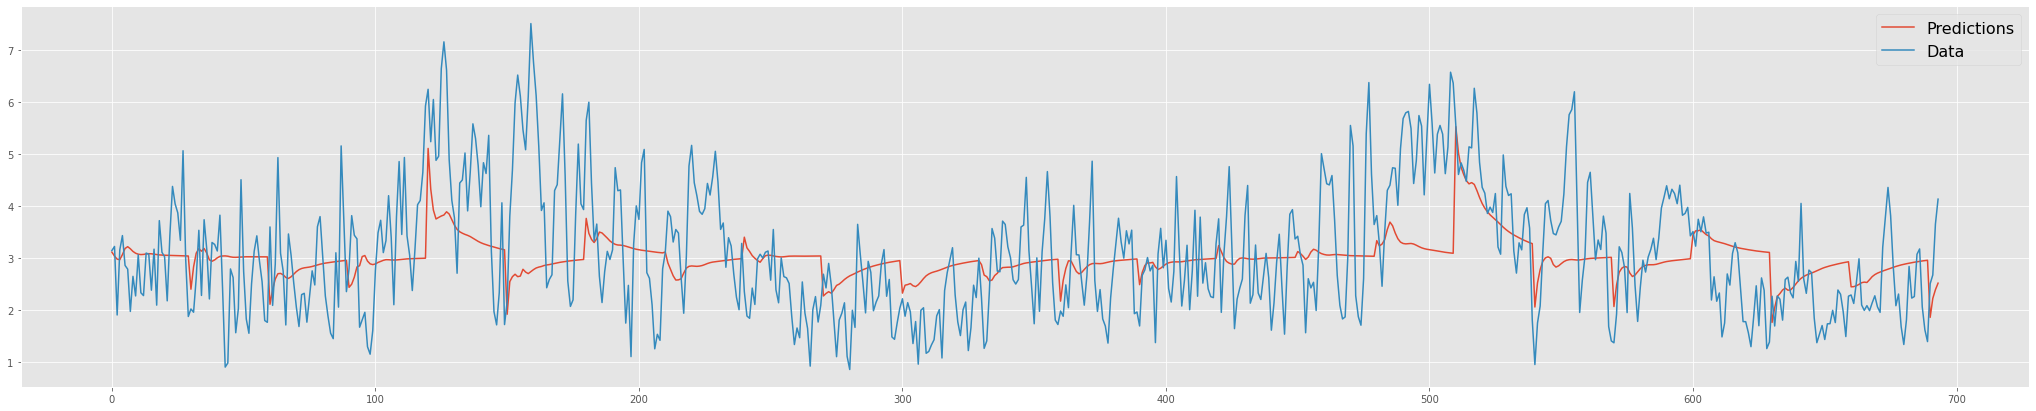

In [15]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(monthly[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,monthly[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks.
# plt.plot(monthly[90:120])
# plt.plot(test_points[90:120])

plt.plot(monthly[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

# MA

In [16]:
# Rolling forecast for MA
history = daily_RJ['Wind Speed']

predictionsMA = []
weeklyMA = []
monthlyMA = []
for t in range(len(test_data)):
  modelMA = ARIMA(history[:train_data_len+t],order = (0,0,8))
  model_fitMA = modelMA.fit()

  if (t)%7==0:
    forecast = model_fitMA.predict(start=t+train_data_len, end=t+train_data_len+6)
    # print(forecast)
    for i in range(7):
      weeklyMA.append(forecast[train_data_len+t+i])
  
  if (t)%30==0:
    forecast = model_fitMA.predict(start=t+train_data_len, end=t+train_data_len+29)
    # print(forecast)
    for i in range(30):
      monthlyMA.append(forecast[train_data_len+t+i])
  
  output = model_fitMA.forecast()
  predVal = output[train_data_len+t]
  predictionsMA.append(predVal)
  # history[len(history)] = test_data[train_data_len+t]

Mean Absolute Percentage Error: 23.68615065991795 %
Mean Sqaured Error: 0.6369112472843833


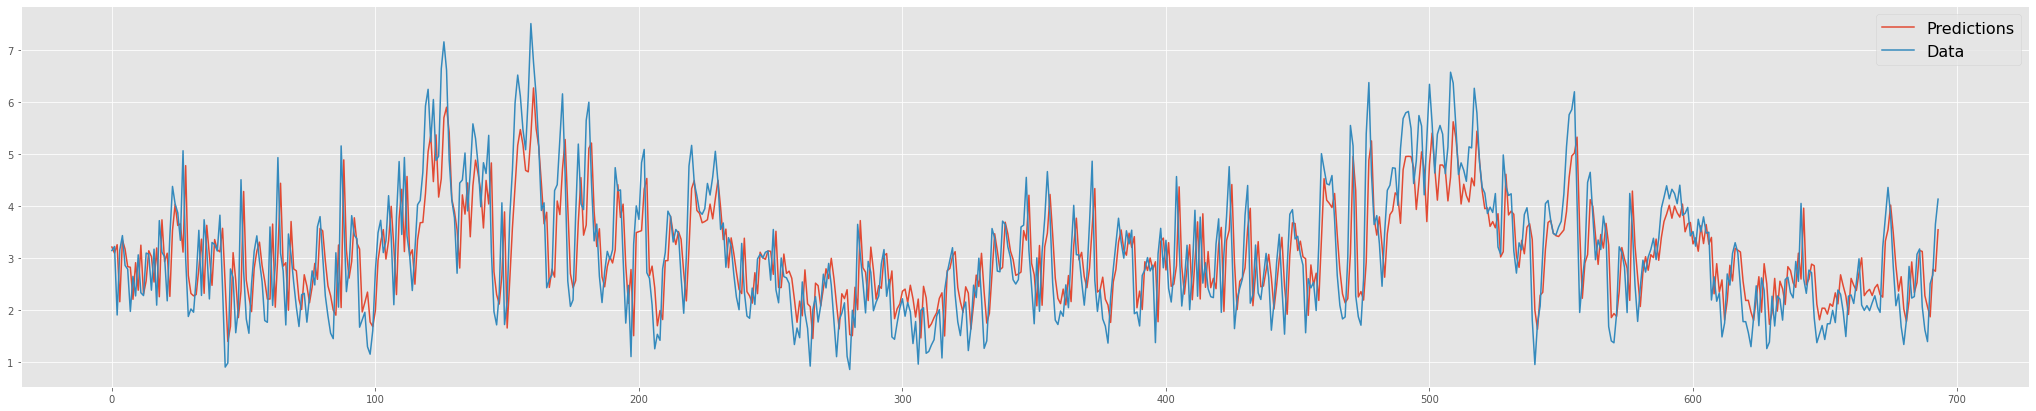

In [17]:
percentage = []
for i in range(len(predictionsMA)):
  percentage.append((abs(predictionsMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,predictionsMA)
print("Mean Sqaured Error: {0}".format(mse))

plt.plot(predictionsMA)
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 33.36213370993794 %
Mean Sqaured Error: 1.2350638475740536


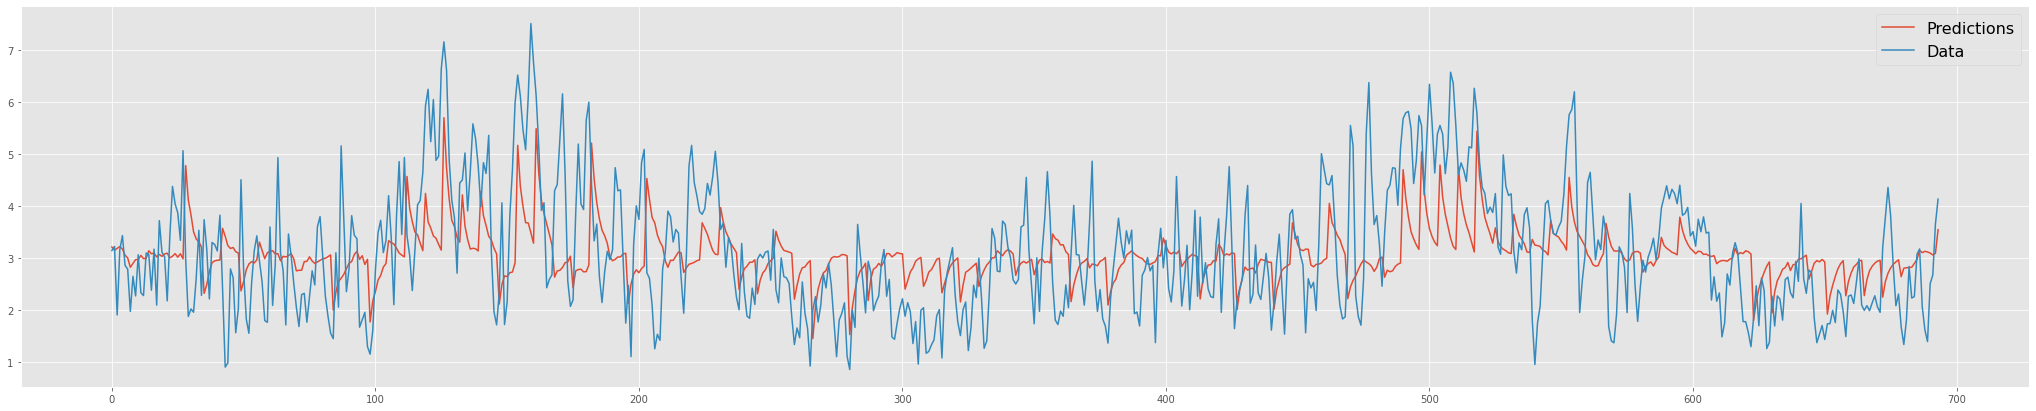

In [18]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(weeklyMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,weeklyMA[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks after training dataset.
# plt.plot(weekly[14:28])
# plt.plot(test_points[14:28])

plt.plot(weeklyMA[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 35.591028405153125 %
Mean Sqaured Error: 1.4454575591875536


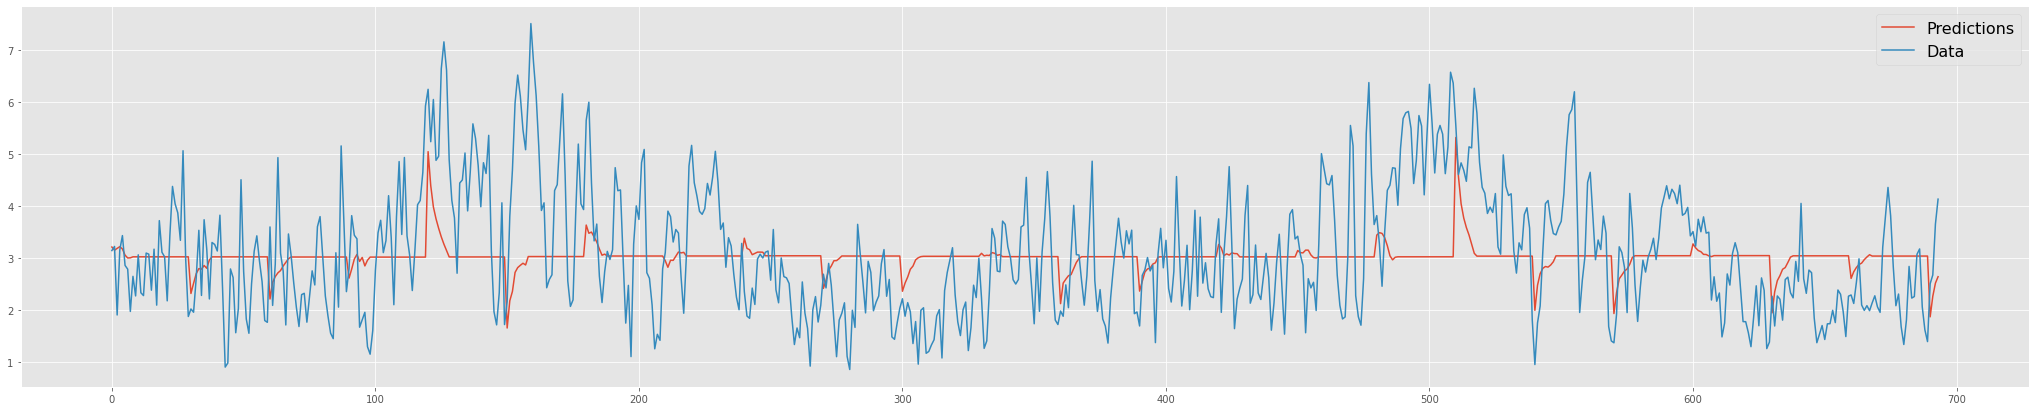

In [19]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(monthlyMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,monthlyMA[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks.
# plt.plot(monthly[90:120])
# plt.plot(test_points[90:120])

plt.plot(monthlyMA[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

# ARIMA

c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:             Wind Speed   No. Observations:                 5205
Model:               ARIMA(12, 1, 10)   Log Likelihood               -6216.778
Date:                Sun, 25 Apr 2021   AIC                          12479.557
Time:                        15:36:19   BIC                          12630.372
Sample:                             0   HQIC                         12532.308
                               - 5205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5349      3.137      0.171      0.865      -5.613       6.683
ar.L2         -0.8123      0.996     -0.816      0.415      -2.764       1.139
ar.L3          0.9390      2.289      0.410      0.6

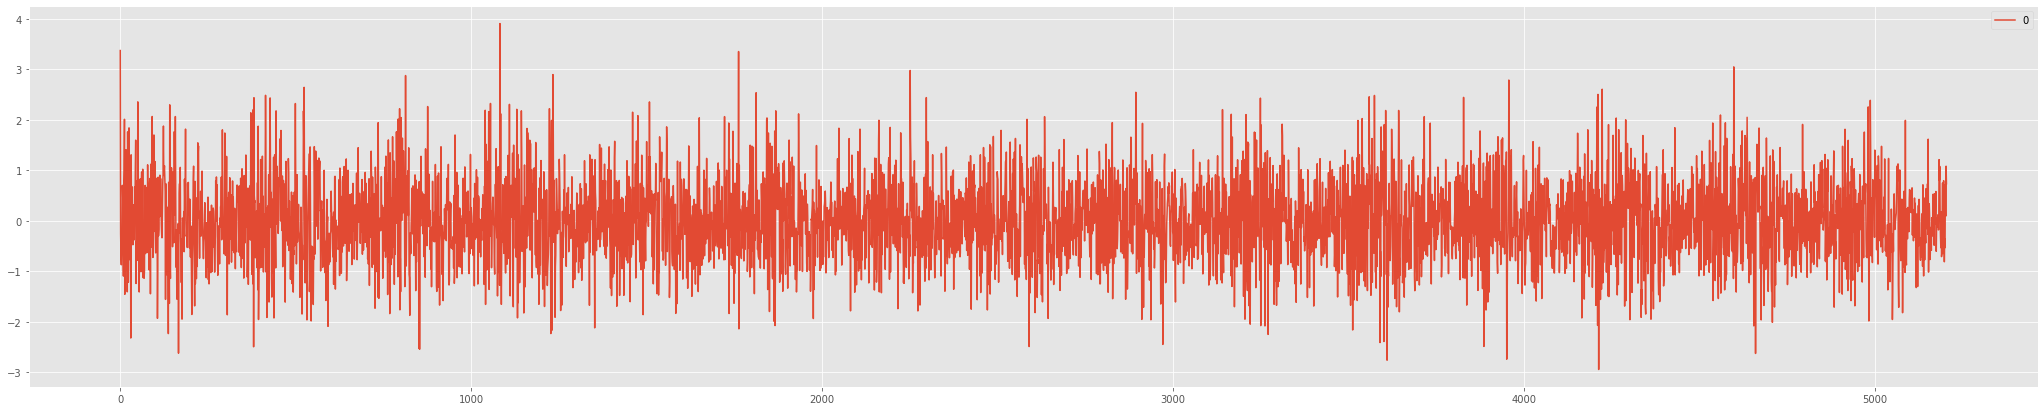

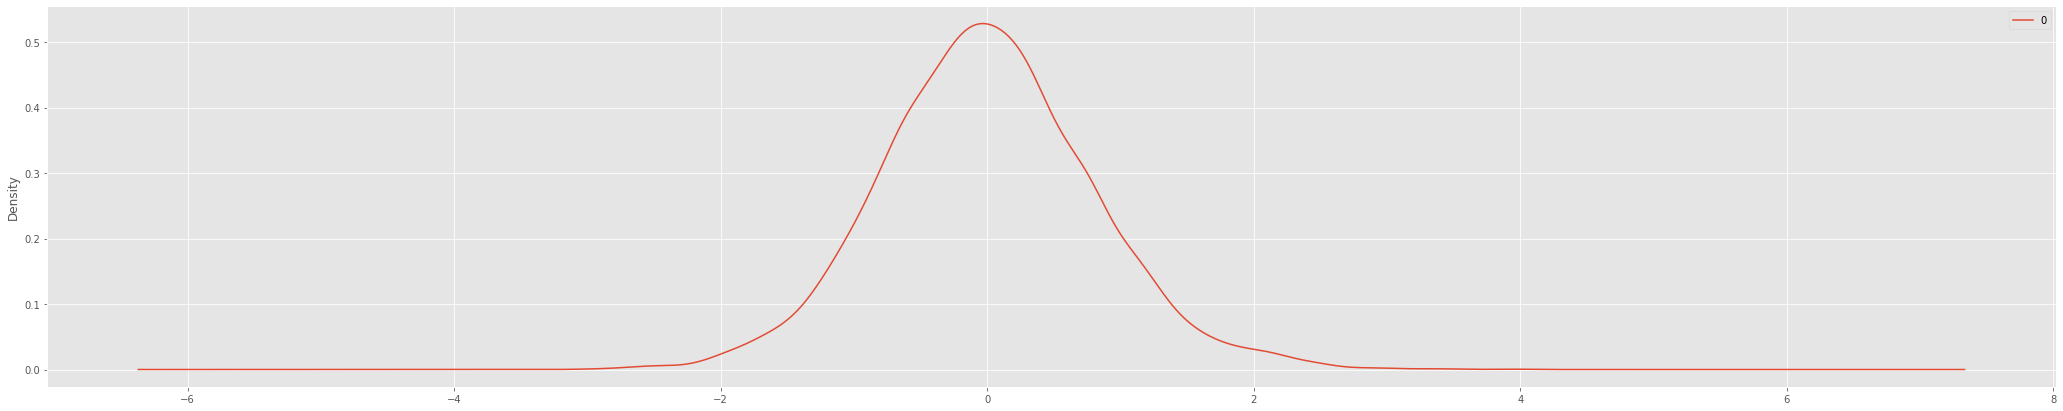

                 0
count  5205.000000
mean      0.000373
std       0.800415
min      -2.943434
25%      -0.526203
50%      -0.018620
75%       0.499797
max       3.908346


In [22]:
modelARIMA = ARIMA(daily_RJ['Wind Speed'],order=(12,1,10))
fit_modelARIMA = modelARIMA.fit()
print(fit_modelARIMA.summary())
residualsARIMA = pd.DataFrame(fit_modelARIMA.resid)
residualsARIMA.plot()
plt.show()
residualsARIMA.plot(kind='kde')
plt.show()
print(residualsARIMA.describe())

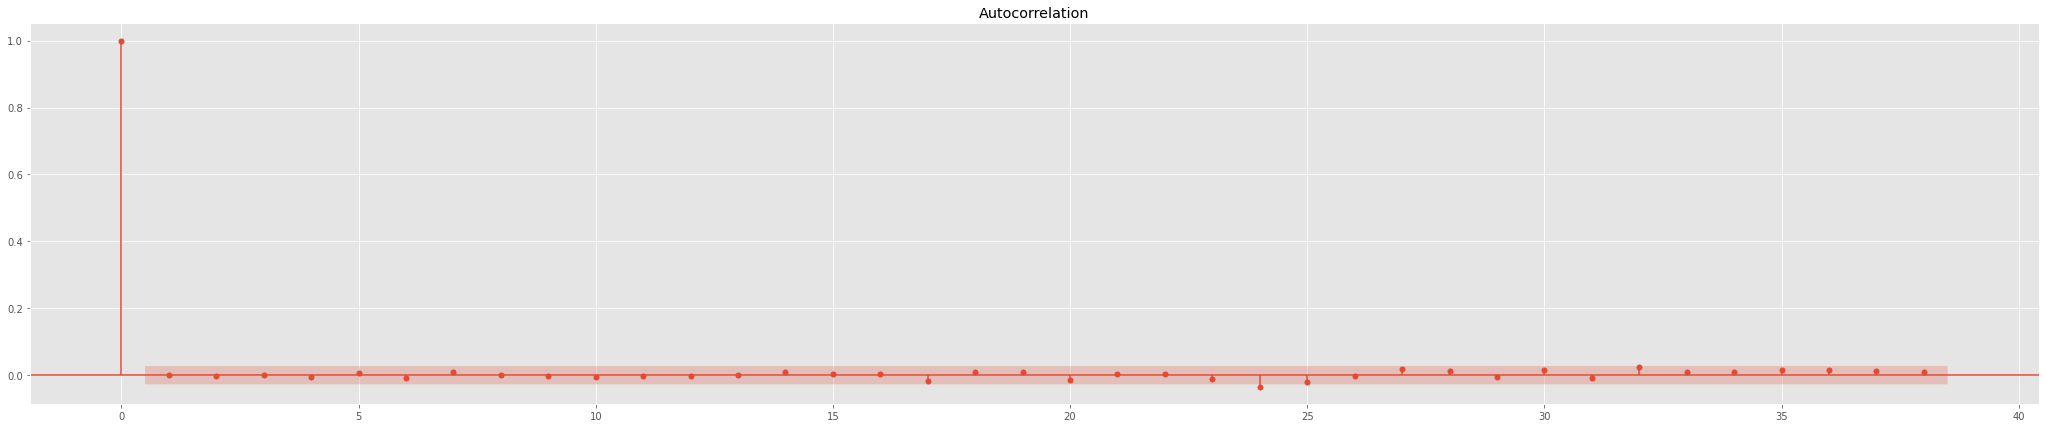

In [23]:
acf_plot = plot_acf(residualsARIMA)

In [26]:
# Finding Forecast Error
percentage = []
for i in range(len(residualsARIMA)):
  if daily_RJ['Wind Speed'][i]==0:
    continue
  percentage.append((abs(residualsARIMA[0][i])/(daily_RJ['Wind Speed'][i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

Mean Absolute Percentage Error: 24.725626776029678 %


# ARMA

In [27]:
# Rolling forecast for ARMA
history = daily_RJ['Wind Speed']

predictionsARMA = []
weeklyARMA = []
monthlyARMA = []
for t in range(len(test_data)):
  modelARMA = ARIMA(history[:train_data_len+t],order = (3,0,1))
  model_fitARMA = modelARMA.fit()

  if (t)%7==0:
    forecast = model_fitARMA.predict(start=t+train_data_len, end=t+train_data_len+6)
    # print(forecast)
    for i in range(7):
      weeklyARMA.append(forecast[train_data_len+t+i])
  
  if (t)%30==0:
    forecast = model_fitARMA.predict(start=t+train_data_len, end=t+train_data_len+29)
    # print(forecast)
    for i in range(30):
      monthlyARMA.append(forecast[train_data_len+t+i])

  output = model_fitARMA.forecast()
  predVal = output[train_data_len+t]
  predictionsARMA.append(predVal)

c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Percentage Error: 22.883090199223563 %
Mean Sqaured Error: 0.594157591660356


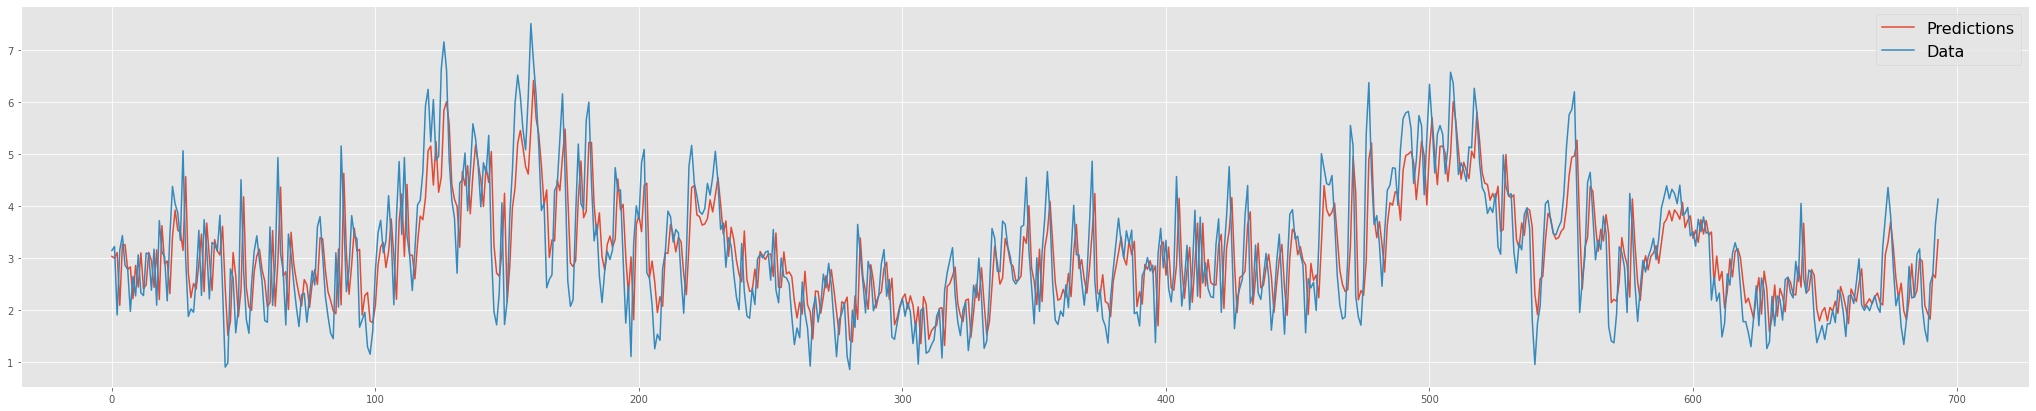

In [28]:
percentage = []
for i in range(len(predictionsARMA)):
  percentage.append((abs(predictionsARMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,predictionsARMA)
print("Mean Sqaured Error: {0}".format(mse))

plt.plot(predictionsARMA)
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 30.48393686383604 %
Mean Sqaured Error: 1.0174501534426028


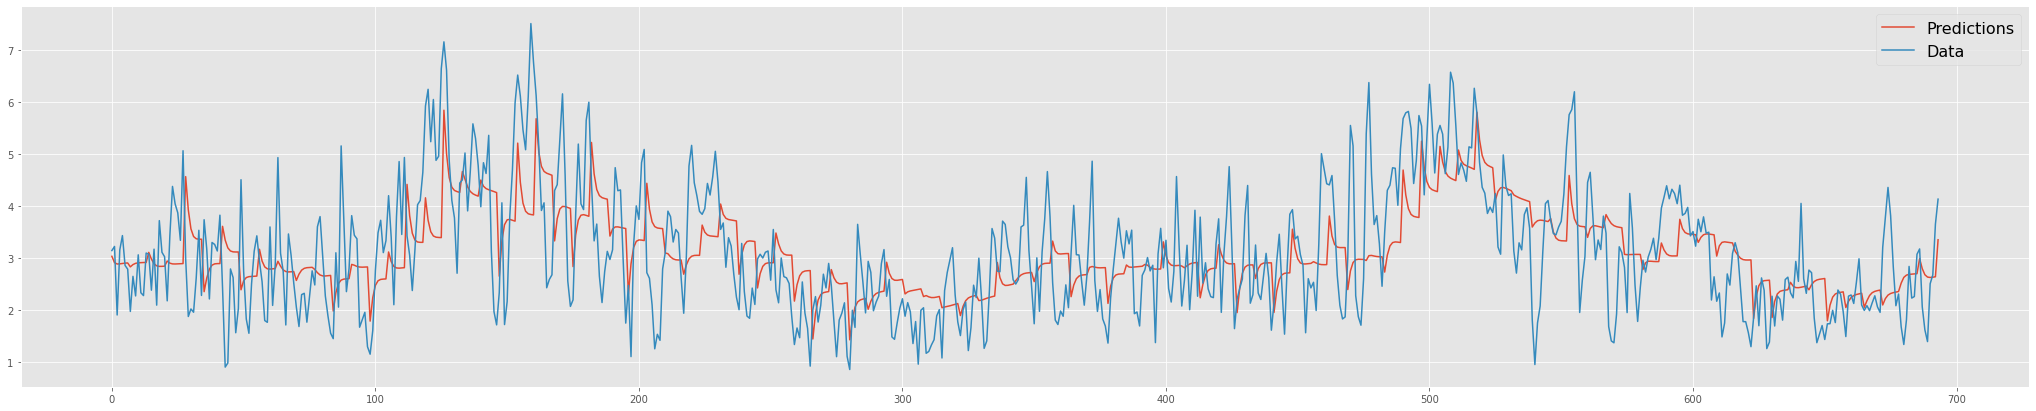

In [29]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(weeklyARMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,weeklyARMA[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks after training dataset.
# plt.plot(weekly[14:28])
# plt.plot(test_points[14:28])

plt.plot(weeklyARMA[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 32.52806227396273 %
Mean Sqaured Error: 1.2237547233273784


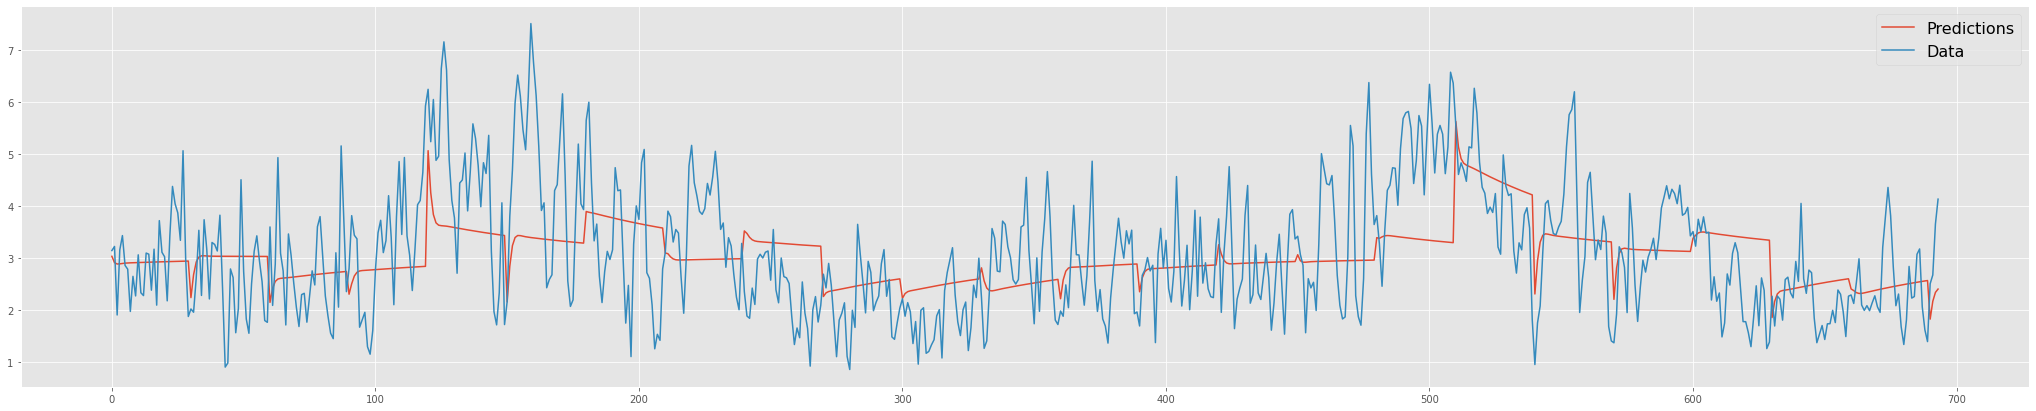

In [30]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(monthlyARMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,monthlyARMA[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks.
# plt.plot(monthly[90:120])
# plt.plot(test_points[90:120])

plt.plot(monthlyARMA[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

# ARIMA

In [33]:
# Rolling forecast for ARIMA
history = daily_RJ['Wind Speed']

predictionsARIMA = []
weeklyARIMA = []
monthlyARIMA = []
for t in range(len(test_data)):
  modelARIMA = ARIMA(history[:train_data_len+t],order = (3,1,1))
  model_fitARIMA = modelARIMA.fit()

  if (t)%7==0:
    forecast = model_fitARIMA.predict(start=t+train_data_len, end=t+train_data_len+6)
    # print(forecast)
    for i in range(7):
      weeklyARIMA.append(forecast[train_data_len+t+i])
  
  if (t)%30==0:
    forecast = model_fitARIMA.predict(start=t+train_data_len, end=t+train_data_len+29)
    # print(forecast)
    for i in range(30):
      monthlyARIMA.append(forecast[train_data_len+t+i])

  output = model_fitARIMA.forecast()
  predVal = output[train_data_len+t]
  predictionsARIMA.append(predVal)
  # history[len(history)] = test_data[train_data_len+t]

c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\91993\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Percentage Error: 22.920697902274245 %
Mean Sqaured Error: 0.5994474783663498


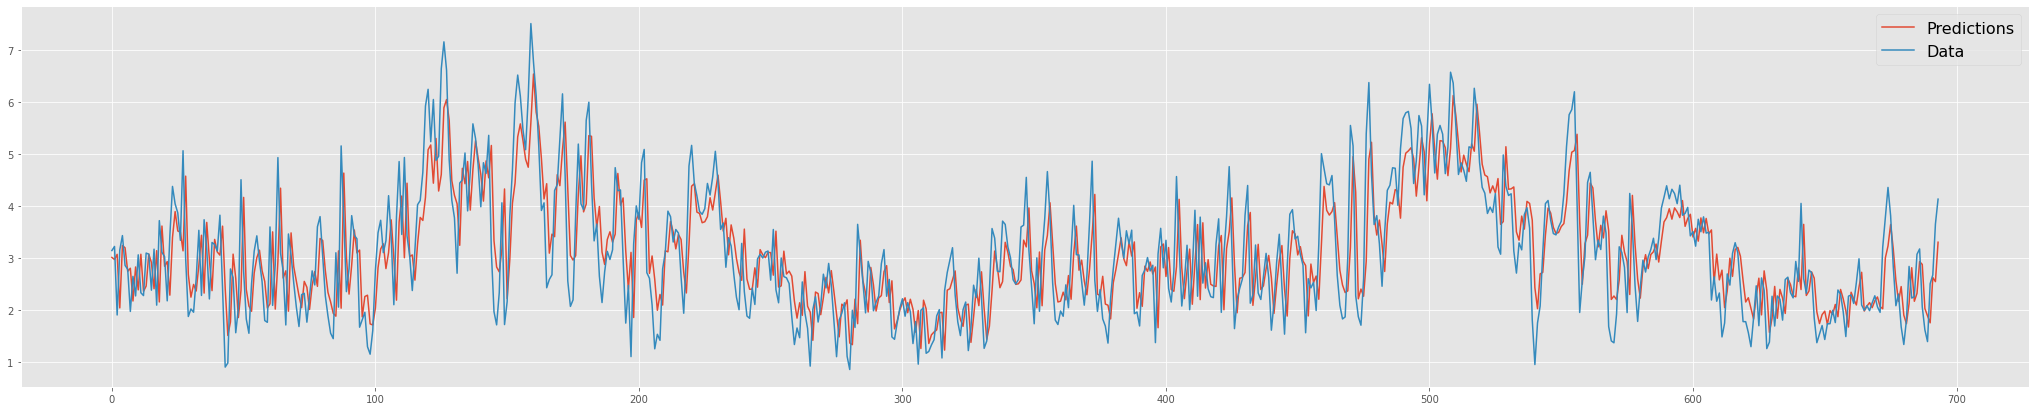

In [34]:
percentage = []
for i in range(len(predictionsARIMA)):
  percentage.append((abs(predictionsARIMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,predictionsARIMA)
print("Mean Sqaured Error: {0}".format(mse))

plt.plot(predictionsARIMA)
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 30.656486195320834 %
Mean Sqaured Error: 1.0512040618058769


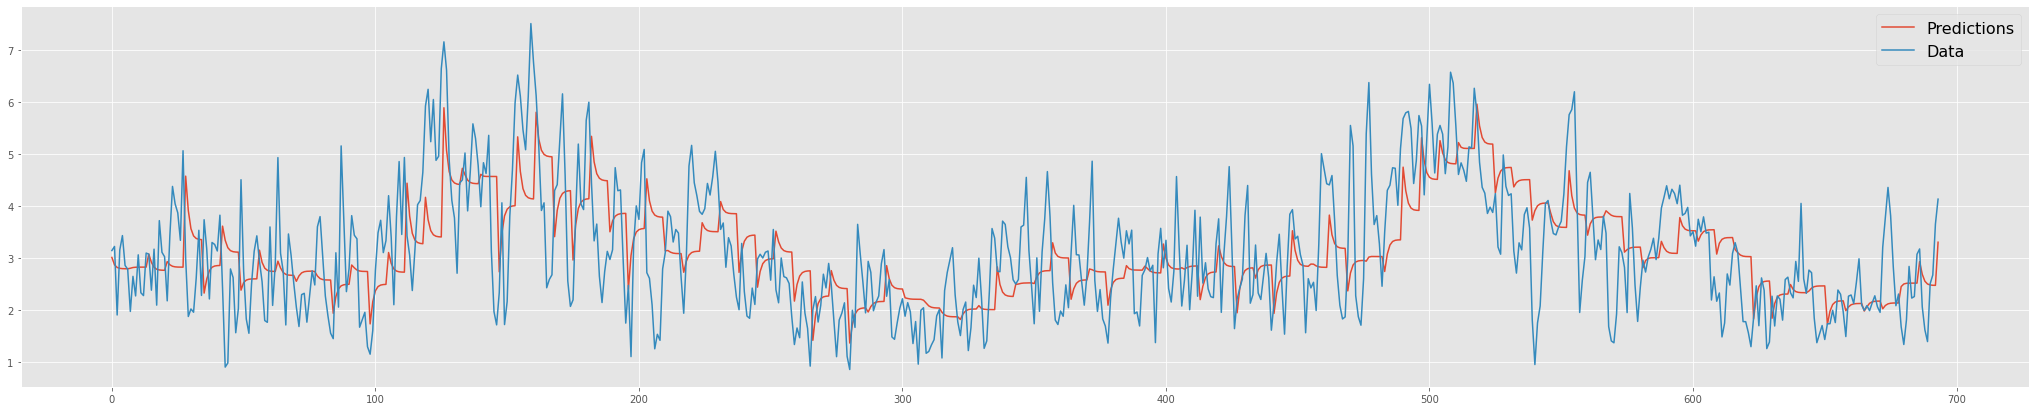

In [35]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(weeklyARIMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,weeklyARIMA[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks after training dataset.
# plt.plot(weekly[14:28])
# plt.plot(test_points[14:28])

plt.plot(weeklyARIMA[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)

Mean Absolute Percentage Error: 33.001902843737355 %
Mean Sqaured Error: 1.289336321669174


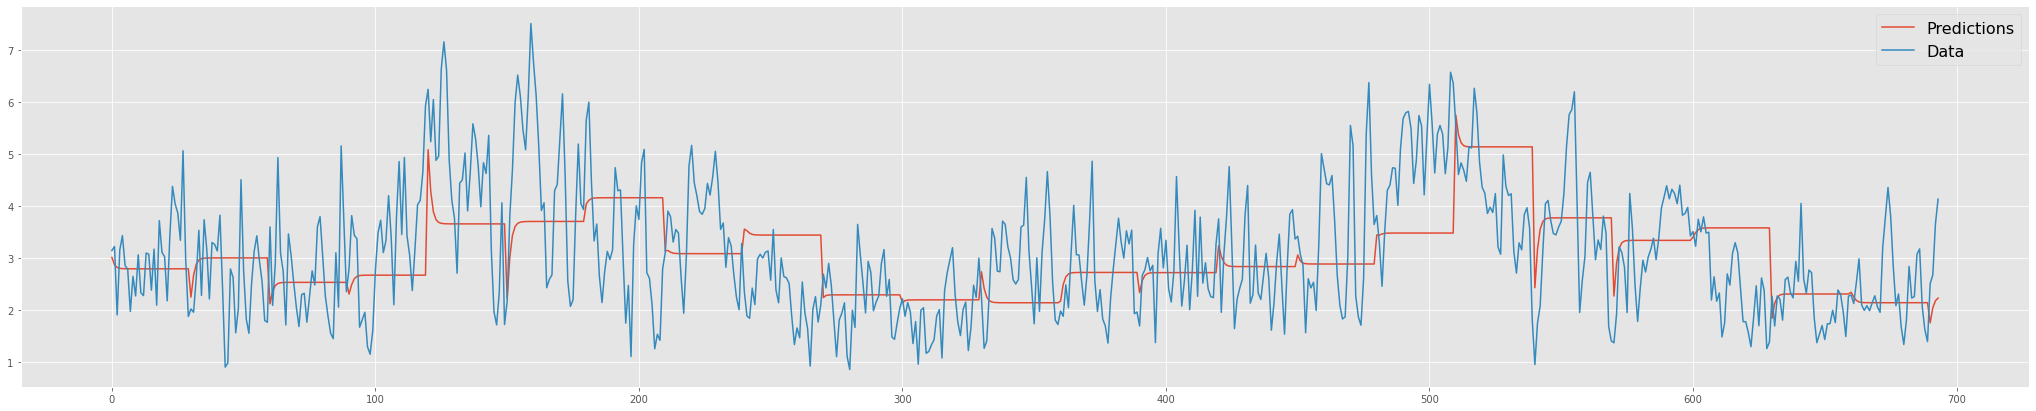

In [36]:
percentage = []
for i in range(len(test_data)):
  percentage.append((abs(monthlyARIMA[i]-test_data[train_data_len+i])/(test_data[train_data_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("Mean Absolute Percentage Error: {0} %".format(mape))

test_points = [x for x in test_data]

mse = mean_squared_error(test_points,monthlyARIMA[:len(test_data)])
print("Mean Sqaured Error: {0}".format(mse))

# Predictions of first two weeks.
# plt.plot(monthly[90:120])
# plt.plot(test_points[90:120])

plt.plot(monthlyARIMA[:len(test_points)])
plt.plot(test_points)

plt.legend(('Predictions','Data'),fontsize=16)